In [59]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tqdm.keras import TqdmCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../../packages/")
from TsIP.TsIP import TsIP
from tools import find_multiple_sets
from LagsCreator.LagsCreator import LagsCreator

## Dataset

In [3]:
COUNTRY = "Yemen"

In [4]:
PATH_TO_DATA_FOLDER = "../../../Dataset time-series/data/" + COUNTRY + "/"

In [5]:
# Load the dataset of the smooth training sets.
train_smooth = pd.read_csv(PATH_TO_DATA_FOLDER + "train_smooth.csv", header = [0, 1], index_col = 0)
train_smooth.index.name = "Datetime"
train_smooth.index = pd.to_datetime(train_smooth.index)
freq = "D"
train_smooth.index.freq = freq

In [6]:
# Load the dataset of the test sets.
test = pd.read_csv(PATH_TO_DATA_FOLDER + "test_target.csv", header = [0, 1], index_col = 0)
test.index.name = "Datetime"
test.index = pd.to_datetime(test.index)
freq = "D"
test.index.freq = freq

In [7]:
# Load the dataset of the whole time-series of the fcs indicator.
target = pd.read_csv(PATH_TO_DATA_FOLDER + "all_target.csv", header = [0, 1], index_col = 0)
target.index.name = "Datetime"
target.index = pd.to_datetime(target.index)
freq = "D"
target.index.freq = freq

In [8]:
TRAIN = train_smooth.copy()

In [9]:
TEST_SIZE = 30
FREQ = TRAIN.index.freq

In [10]:
PROVINCES = TRAIN.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [11]:
PREDICTORS = TRAIN.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly (%) Rainfall', '3 Months Anomaly (%) Rainfall',
       'Cereals and tubers', 'Exchange rate (USD/LCU)', 'FCS', 'Fatality',
       'Lat', 'Lon', 'NDVI Anomaly', 'Population', 'Rainfall (mm)', 'Ramadan',
       'rCSI'],
      dtype='object', name='Indicator')

## Data source transformation

I decide to normalize the data among the provinces considering indicator by indicator and considering only the training sets.

In [12]:
global SCALERS

MIN = 0
MAX = 1
SCALERS = dict()
def normalization(group, feature_range):
    min_, max_ = feature_range
    min_group = group.min().min()
    max_group = group.max().max()
    
    # Normalization.
    group_std = (group - min_group) / (max_group - min_group)
    group_scaled = group_std * (max_ - min_) + min_

    # Save the scalers for the various indicators.
    SCALERS[group.name] = (min_group, max_group)

    return group_scaled

In [13]:
TRAIN_NORMALIZED = TRAIN.groupby(axis = 1, level = 1).apply(lambda x: normalization(x, (MIN, MAX)))
TRAIN_NORMALIZED.head()

AdminStrata                        Abyan                                \
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2018-08-22                      0.202614                      0.327464   
2018-08-23                      0.201694                      0.323172   
2018-08-24                      0.200218                      0.317813   
2018-08-25                      0.198491                      0.312132   
2018-08-26                      0.196724                      0.306528   

AdminStrata                                                                 \
Indicator   Cereals and tubers Exchange rate (USD/LCU)       FCS  Fatality   
Datetime                                                                     
2018-08-22            0.109379                0.097113  0.398119  0.016014   
2018-08-23            0.115215                0.108255  0.416745  0.014270   
2018-08-24            0.118301                0.112477  0.422543  0.014297   
2018-08-25            0.119918                0.113002  0.424258  0.015185   
2018-08-26            0.121119                0.112481  0.427209  0.016327   

AdminStrata                                              ...  \
Indicator         Lat       Lon NDVI Anomaly Population  ...   
Datetime                                                 ...   
2018-08-22   0.204339  0.354998     0.203677   0.137715  ...   
2018-08-23   0.204339  0.354998     0.201767   0.137715  ...   
2018-08-24   0.204339  0.354998     0.199870   0.137715  ...   
2018-08-25   0.204339  0.354998     0.197950   0.137715  ...   
2018-08-26   0.204339  0.354998     0.195990   0.137715  ...   

AdminStrata                   Taizz                                        \
Indicator   Exchange rate (USD/LCU)       FCS  Fatality      Lat      Lon   
Datetime                                                                    
2018-08-22                 0.100691  0.521481  0.124455  0.13656  0.07253   
2018-08-23                 0.105181  0.505624  0.118668  0.13656  0.07253   
2018-08-24                 0.109271  0.494372  0.115789  0.13656  0.07253   
2018-08-25                 0.113148  0.486382  0.115893  0.13656  0.07253   
2018-08-26                 0.116965  0.480822  0.118913  0.13656  0.07253   

AdminStrata                                                          
Indicator   NDVI Anomaly Population Rainfall (mm) Ramadan      rCSI  
Datetime                                                             
2018-08-22      0.317287   0.894478      0.430215     0.0  0.522625  
2018-08-23      0.314277   0.894478      0.436639     0.0  0.513277  
2018-08-24      0.311164   0.894478      0.446466     0.0  0.511028  
2018-08-25      0.307901   0.894478      0.458051     0.0  0.511425  
2018-08-26      0.304470   0.894478      0.470108     0.0  0.512072  

[5 rows x 260 columns]

In [14]:
# Plot time-series.
#TsIP(TRAIN_NORMALIZED).interactive_plot_df(title = "Training sets", matplotlib = False, style = "lines")

In [15]:
def denormalization(group_scaled, indicator, feature_range, scalers):
    min_, max_ = feature_range
    min_group, max_group = scalers[indicator]

    group_std = (group_scaled - min_) / (max_ - min_)
    group = (group_std * (max_group - min_group)) + min_group
    
    return group

In [16]:
# Get the training and test sets.
TRAIN_NORMALIZED_SETS = find_multiple_sets(TRAIN_NORMALIZED)
TEST_TARGET_SETS = find_multiple_sets(test)

## Training

In [17]:
N_SEQ = 2
N_STEPS = 7
LAGS = N_SEQ*N_STEPS

In [18]:
lags_dict = dict()
# Define lags for each indicator.
lags_dict["3 Months Anomaly (%) Rainfall"] = LAGS
lags_dict["1 Month Anomaly (%) Rainfall"] = LAGS
lags_dict["Cereals and tubers"] = LAGS
lags_dict["Exchange rate (USD/LCU)"] = LAGS
lags_dict["FCS"] = LAGS
lags_dict["Fatality"] = LAGS
lags_dict["NDVI Anomaly"] = LAGS
lags_dict["Rainfall (mm)"] = LAGS
lags_dict["rCSI"] = LAGS
lags_dict["Lat"] = LAGS
lags_dict["Lon"] = LAGS
lags_dict["Population"] = LAGS
lags_dict["Ramadan"] = LAGS

In [19]:
X_train_list, y_train_list = list(), list()
X_test_dict = dict() 
for i, train_normalized in enumerate(TRAIN_NORMALIZED_SETS):
    # Create training points from the training set.
    for PROVINCE in PROVINCES:
        # Initialize lags creator.
        creator = LagsCreator(train_normalized[[PROVINCE]], lags_dictionary = lags_dict, target = "FCS")
        # Get samples.
        X_train, y_train, _, _, X_test = creator.to_supervised(n_out = TEST_SIZE, single_step = False, return_dataframe = False, 
                                                               feature_time = False, validation = False, dtype = np.float32)
    
        # Add a list of all the training samples of all the provinces together.
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        
        # Add the test sample of the province of the current set into a dictionary.
        X_test_dict[(PROVINCE, i)] = X_test

# Merge all the provinces. (n_samples, time-steps, n_features)
X_train = np.concatenate(X_train_list)
# Merge all the provinces. (n_samples, n_out)
y_train = np.concatenate(y_train_list)

print("Training shape: X:", X_train.shape, "y:", y_train.shape)

Training shape: X: (7980, 14, 13) y: (7980, 30)


In [20]:
N_FEATURES = X_train.shape[2]

In [21]:
BATCH_SIZE = 512
N_EPOCHS = 1

In [22]:
def network(timesteps, features, n_out):      
    model = Sequential() 

    # MODEL.
    model.add(TimeDistributed(Conv1D(3, 2, activation = "relu", input_shape = (None, N_STEPS, N_FEATURES))))
    model.add(TimeDistributed(Conv1D(3, 2, activation = "relu", )))
    model.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(10, activation = "relu", return_sequences = False))

    model.add(Dense(n_out))  

    return model

In [23]:
# Reshape the data in order to be fed to this network.
X_train = X_train.reshape((X_train.shape[0], N_SEQ, N_STEPS, N_FEATURES))

In [24]:
TRIALS = 5

In [25]:
FORECASTING_TRIALS = list()
for TRIAL in range(TRIALS):
    model = network(LAGS, N_FEATURES, TEST_SIZE)
    # Compile model.
    model.compile(loss = "mse", optimizer = "adam")
    # Fit model.
    history = model.fit(X_train, y_train, epochs = N_EPOCHS, batch_size = BATCH_SIZE, verbose = 0, shuffle = True, 
                        callbacks = [TqdmCallback(verbose = 1)])

    FORECASTING_NORMALIZED = test.copy()
    # Prediction over the test sets.
    for i, test_set in enumerate(TEST_TARGET_SETS):
        # Prediction for each province.
        for PROVINCE in PROVINCES:
            X_test = X_test_dict[(PROVINCE, i)]
            X_test = X_test.reshape((X_test.shape[0], N_SEQ, N_STEPS, N_FEATURES))
            # Prediction.
            y_hats = model.predict(X_test, verbose = 0).flatten() 
            # Add the prediction to the dataframe.
            FORECASTING_NORMALIZED[(PROVINCE, "FCS")].loc[test_set.index] = y_hats
    # Denormalization.
    FORECASTING = denormalization(FORECASTING_NORMALIZED, "FCS", (MIN, MAX), SCALERS)
    FORECASTING.columns.set_levels(["Trial_%d" % (TRIAL+1)], level = 1, inplace = True)
    FORECASTING_TRIALS.append(FORECASTING)
    
    # Clear.
    clear_output(wait = True)
    K.clear_session()

In [26]:
FORECASTING_TRIALS = pd.concat(FORECASTING_TRIALS, axis = 1).sort_index(axis = 1, level = 0)

In [50]:
q25 = FORECASTING_TRIALS.groupby(axis = 1, level = 0).quantile(q = 0.25)
q25.columns = pd.MultiIndex.from_product([q25.columns, ["predicted_quantile_25"]])
q75 = FORECASTING_TRIALS.groupby(axis = 1, level = 0).quantile(q = 0.75)
q75.columns = pd.MultiIndex.from_product([q75.columns, ["predicted_quantile_75"]])
mean = FORECASTING_TRIALS.groupby(axis = 1, level = 0).mean()
mean.columns = pd.MultiIndex.from_product([mean.columns, ["predicted_mean"]])
original = target.copy()
original.columns.set_levels(["original"], level = 1, inplace = True)

In [51]:
FORECASTING_STATISTIC = pd.concat([q25, mean, q75, original], axis = 1).sort_index(axis = 1, level = 0)
FORECASTING_STATISTIC.columns.rename("AdminStrata", level = 0, inplace = True)
FORECASTING_STATISTIC.columns.rename("Statistic", level = 1, inplace = True)

In [52]:
FORECASTING_STATISTIC.head()

AdminStrata      Abyan                                       \
Statistic     original predicted_mean predicted_quantile_25   
Datetime                                                      
2018-07-02   31.158690            NaN                   NaN   
2018-07-03   32.675222            NaN                   NaN   
2018-07-04   33.415597            NaN                   NaN   
2018-07-05   33.531451            NaN                   NaN   
2018-07-06   33.951856            NaN                   NaN   

AdminStrata                             Aden                 \
Statistic   predicted_quantile_75   original predicted_mean   
Datetime                                                      
2018-07-02                    NaN  16.619519            NaN   
2018-07-03                    NaN  16.370603            NaN   
2018-07-04                    NaN  15.089163            NaN   
2018-07-05                    NaN  15.766521            NaN   
2018-07-06                    NaN  16.870065            NaN   

AdminStrata                                               Al Bayda  \
Statistic   predicted_quantile_25 predicted_quantile_75   original   
Datetime                                                             
2018-07-02                    NaN                   NaN  38.332669   
2018-07-03                    NaN                   NaN  43.292084   
2018-07-04                    NaN                   NaN  45.128205   
2018-07-05                    NaN                   NaN  43.959297   
2018-07-06                    NaN                   NaN  44.516521   

AdminStrata                 ...                Sana'a                        \
Statistic   predicted_mean  ... predicted_quantile_25 predicted_quantile_75   
Datetime                    ...                                               
2018-07-02             NaN  ...                   NaN                   NaN   
2018-07-03             NaN  ...                   NaN                   NaN   
2018-07-04             NaN  ...                   NaN                   NaN   
2018-07-05             NaN  ...                   NaN                   NaN   
2018-07-06             NaN  ...                   NaN                   NaN   

AdminStrata    Shabwah                                       \
Statistic     original predicted_mean predicted_quantile_25   
Datetime                                                      
2018-07-02   16.752289            NaN                   NaN   
2018-07-03   18.257453            NaN                   NaN   
2018-07-04   19.083081            NaN                   NaN   
2018-07-05   20.349533            NaN                   NaN   
2018-07-06   21.107524            NaN                   NaN   

AdminStrata                            Taizz                 \
Statistic   predicted_quantile_75   original predicted_mean   
Datetime                                                      
2018-07-02                    NaN  26.563365            NaN   
2018-07-03                    NaN  29.124005            NaN   
2018-07-04                    NaN  29.427973            NaN   
2018-07-05                    NaN  30.456026            NaN   
2018-07-06                    NaN  31.012517            NaN   

AdminStrata                                              
Statistic   predicted_quantile_25 predicted_quantile_75  
Datetime                                                 
2018-07-02                    NaN                   NaN  
2018-07-03                    NaN                   NaN  
2018-07-04                    NaN                   NaN  
2018-07-05                    NaN                   NaN  
2018-07-06                    NaN                   NaN  

[5 rows x 80 columns]

In [64]:
TsIP(FORECASTING_STATISTIC).interactive_plot_predictions(title = "Forecasting", matplotlib = False, style = "lines", quantiles = True)

interactive(children=(ToggleButtons(description='AdminStrata', options=('Abyan', 'Aden', 'Al Bayda', "Al Dhale…

In [68]:
FORECASTING = FORECASTING_STATISTIC.xs("predicted_mean", axis = 1, level = 1, drop_level = False)
#FORECASTING.columns.set_levels(["FCS"], level = 1, inplace = True)

In [69]:
FORECASTING_TARGET_SETS = find_multiple_sets(FORECASTING)

In [70]:
from sklearn.metrics import mean_squared_error

# Loss.
losses = list()
losses_h = list()
for test_set, forecasting_set in zip(TEST_TARGET_SETS, FORECASTING_TARGET_SETS):
    loss = mean_squared_error(test_set, forecasting_set)
    losses.append(loss)
    loss_h = mean_squared_error(test_set.transpose(), forecasting_set.transpose(), multioutput = "raw_values")    
    losses_h.append(loss_h)

In [71]:
np.mean(losses)

1058.056590934522

In [ ]:
# Load naive model forecasting results.
naive = np.load("../../Naive_yemen.npy")

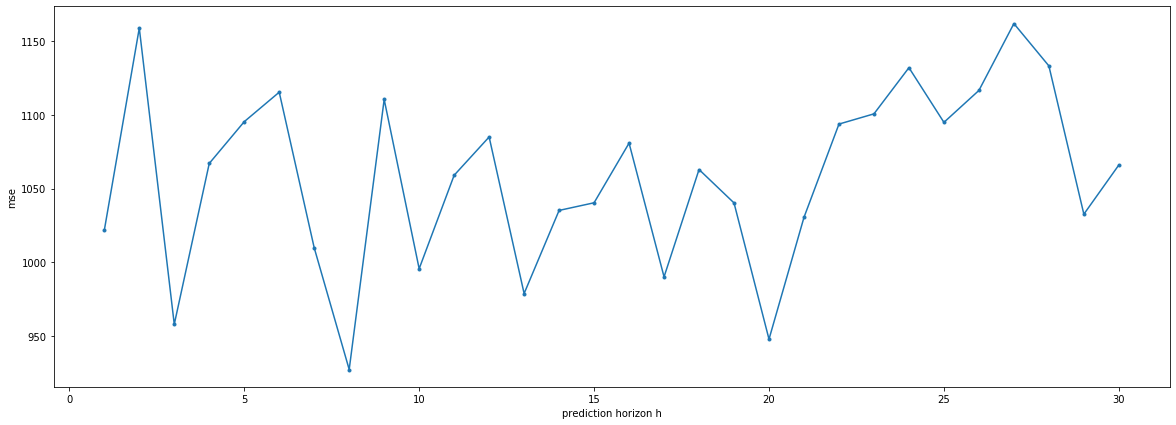

In [72]:
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(np.arange(1, TEST_SIZE + 1), np.mean(losses_h, axis = 0), ".-", label = "LSTM")
ax.plot(naive[0], naive[1], ".-", label = "Naive")
ax.set_ylabel("mse", fontsize = 10)
ax.set_xlabel("prediction horizon h", fontsize = 10)
ax.legend();